In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import warnings

In [2]:
df = pd.read_csv('data/LoadData.csv')
df.head()

Date       N_Y_C_
0  05/01/2007 00:00:00  4854.400000
1  05/01/2007 00:15:00  4777.370779
2  05/01/2007 00:30:00  4729.483400
3  05/01/2007 00:45:00  4682.387550
4  05/01/2007 01:00:00  4587.337550

In [3]:
df.shape

(414916, 2)

                 N_Y_C_
Timestamp              
2007-05-01  5666.252902
2007-05-02  5666.180415
2007-05-03  5662.574479
2007-05-04  5615.351488
2007-05-05  5032.153638
...                 ...
2019-02-24  5144.902344
2019-02-25  5790.148177
2019-02-26  6000.704688
2019-02-27  6114.133594
2019-02-28  5978.750781

[4322 rows x 1 columns]


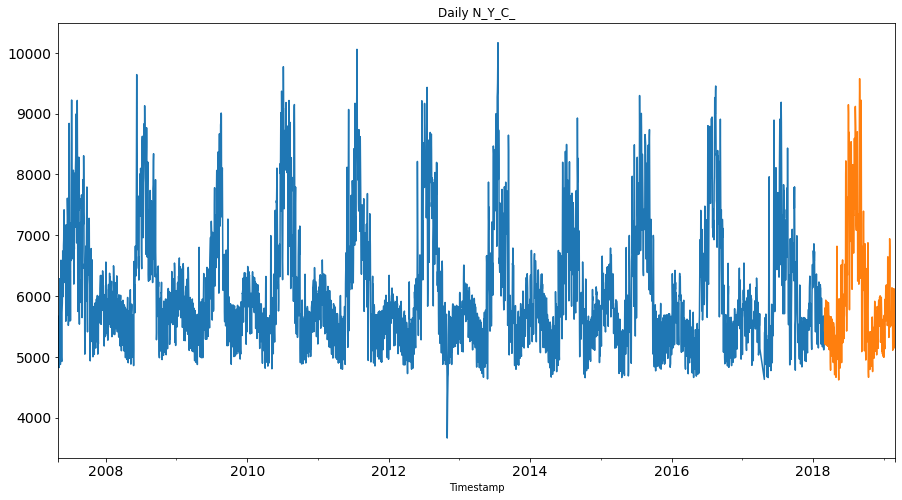

In [4]:
# Creating train and test set
# Index 379877 marks the start of March 2018
train = df[0:379876]
test = df[379877:]

# Aggregating the dataset at daily level
df['Timestamp'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %H:%M:%S')
df.index = df['Timestamp']
df = df.resample('D').mean()
print(df)

train['Timestamp'] = pd.to_datetime(train['Date'], format='%m/%d/%Y %H:%M:%S')
train.index = train['Timestamp']
train = train.resample('D').mean()

test['Timestamp'] = pd.to_datetime(test['Date'], format='%m/%d/%Y %H:%M:%S')
test.index = test['Timestamp']
test = test.resample('D').mean()

# Plotting data
train.N_Y_C_.plot(figsize=(15, 8), title='Daily N_Y_C_', fontsize=14)
test.N_Y_C_.plot(figsize=(15, 8), title='Daily N_Y_C_', fontsize=14)
plt.show()

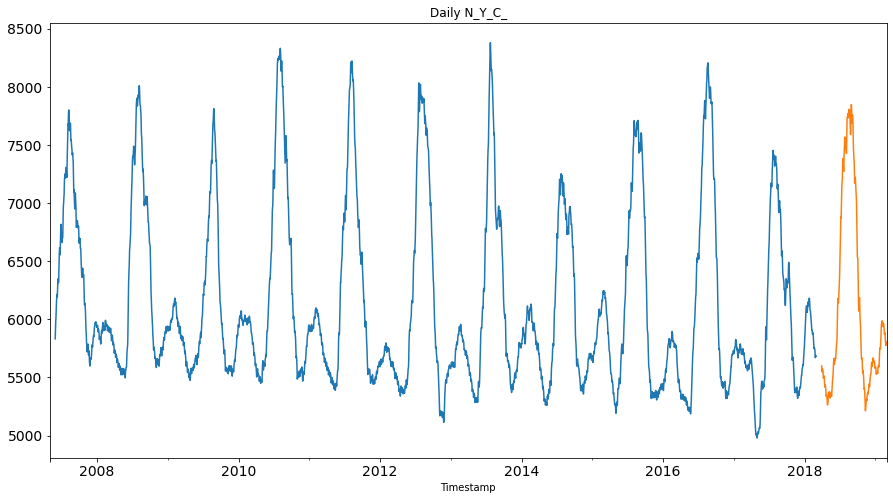

In [5]:
# smooth the graph
df_mean = df.rolling(window=30).mean()
train_mean = train.N_Y_C_.rolling(window=30).mean()
test_mean = test.N_Y_C_.rolling(window=30).mean()
train_mean.plot(figsize=(15, 8), title='Daily N_Y_C_', fontsize=14)
test_mean.plot(figsize=(15, 8), title='Daily N_Y_C_', fontsize=14)
plt.show()

## SARIMAモデル（季節自己回帰和分移動平均モデル）

- SARIMA モデル = ARIMA モデル + 周期的変動
- ARIMA モデル = ARMA モデル + データの差分
- ARMA モデル = AR モデル + MA モデル

`AR モデル`（自己回帰モデル）は，時間の変化に対し規則的に値が変化する時系列モデルである. AR モデルはある時点のデータがそれ以前のデータで回帰的に推定できるモデルである．

`MA モデル`（移動平均モデル）は，時間の変化に対し不規則に値が変化するが，ある区間での変動が一定であるようにモデルを考える．

`ARMAモデル`は過去の値から回帰的に推定可能な要素と過去の誤差に影響を受け，推定が難しい要素が組み合わさったモデルである．

`ARIMA モデル`（自己回帰和分移動平均モデル）は，ARMA モデルを非定常性に対応したものである．

`SARIMA モデル`（季節自己回帰和分移動平均モデル）は，ARIMA モデルにさらに長期的な季節（あるいは周期）変動を取り入れたモデルである．


In [6]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12)
                for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [7]:
warnings.filterwarnings("ignore")  # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param, seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01489D+01    |proj g|=  6.39488D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.395D-09   1.015D+01
  F =   10.148948557539496     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:87729.51133137141
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.77977D+00    |proj g|=  6.84892D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   1.101D-04   9.780D+00
  F =   9.7797671426417931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:84540.30718099566
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19584D+00    |proj g|=  3.14841D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:70846.86265682183
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.09286D+00    |proj g|=  9.09081D-02

At iterate    5    f=  8.08971D+00    |proj g|=  1.63716D-04

At iterate   10    f=  8.08968D+00    |proj g|=  7.98540D-03

At iterate   15    f=  8.08746D+00    |proj g|=  5.06878D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     22      1     0     0   3.463D-06   8.086D+00
  F =   8.0859258611822398     

CONVERGENCE: N

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   2.382D-04   8.195D+00
  F =   8.1951032268152311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:70842.47229259086
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17784D+00    |proj g|=  3.70237D+00


 This problem is unconstrained.



At iterate    5    f=  8.14919D+00    |proj g|=  1.81932D+00

At iterate   10    f=  8.11316D+00    |proj g|=  5.95431D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   1.141D-04   8.113D+00
  F =   8.1131104253140336     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:70135.7265164145
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.10821D+00    |proj g|=  5.69695D-06

           * * 

 This problem is unconstrained.


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:70091.40701182744
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.09648D+00    |proj g|=  8.95478D-02


 This problem is unconstrained.



At iterate    5    f=  8.08601D+00    |proj g|=  2.94410D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   4.143D-05   8.086D+00
  F =   8.0860111478896055     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:69901.48036235775
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.93122D+00    |proj g|=  7.35434D-01

At iterate    5    f=  9.77691D+00    |proj g|=  9.70570D-02


 This problem is unconstrained.



At iterate   10    f=  9.77556D+00    |proj g|=  1.18844D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     22      1     0     0   1.188D-04   9.776D+00
  F =   9.7755629408195670     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:84503.96606044433
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85972D+00    |proj g|=  7.72341D-01


 This problem is unconstrained.



At iterate    5    f=  9.66238D+00    |proj g|=  3.30717D-02

At iterate   10    f=  9.66137D+00    |proj g|=  1.46703D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     22      1     0     0   1.467D-04   9.661D+00
  F =   9.6613714641688535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:83518.89493627557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86457D+00    |proj g|=  3.98764D-01

At iterate    

 This problem is unconstrained.


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:67774.4667471061
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.78197D+00    |proj g|=  1.34905D+00


 This problem is unconstrained.



At iterate    5    f=  7.71803D+00    |proj g|=  1.82538D-02

At iterate   10    f=  7.71795D+00    |proj g|=  3.85803D-04

At iterate   15    f=  7.71790D+00    |proj g|=  1.11980D-02

At iterate   20    f=  7.71341D+00    |proj g|=  1.11132D-01

At iterate   25    f=  7.69912D+00    |proj g|=  2.73723D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     32      1     0     0   1.316D-07   7.699D+00
  F =   7.6991165271576172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:66557.16326075044
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  9.62550D+00    |proj g|=  2.02910D-03

At iterate   10    f=  9.62539D+00    |proj g|=  4.68939D-04

At iterate   15    f=  9.62476D+00    |proj g|=  6.90973D-03

At iterate   20    f=  9.52756D+00    |proj g|=  5.07596D-02
  ys=-5.412E-01  -gs= 9.378E-01 BFGS update SKIPPED

At iterate   25    f=  7.85177D+00    |proj g|=  1.19546D-01

At iterate   30    f=  7.83943D+00    |proj g|=  2.59262D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     57      1     1     0   1.287D-04   7.839D+00
  F =   7.8394240675383973     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.



At iterate    5    f=  9.62011D+00    |proj g|=  2.81864D-03

At iterate   10    f=  9.61999D+00    |proj g|=  1.70625D-04

At iterate   15    f=  9.61992D+00    |proj g|=  8.78342D-03

At iterate   20    f=  9.61539D+00    |proj g|=  3.34052D-02

At iterate   25    f=  9.60478D+00    |proj g|=  7.93146D-02

At iterate   30    f=  9.15140D+00    |proj g|=  5.08971D+00

At iterate   35    f=  8.43964D+00    |proj g|=  1.05824D+00

At iterate   40    f=  8.07489D+00    |proj g|=  8.56532D-01

At iterate   45    f=  7.74937D+00    |proj g|=  1.23761D+00

At iterate   50    f=  7.72374D+00    |proj g|=  3.92955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.74383D+00    |proj g|=  5.86209D-03

At iterate   10    f=  7.74380D+00    |proj g|=  2.07387D-03

At iterate   15    f=  7.74345D+00    |proj g|=  3.48866D-02

At iterate   20    f=  7.73467D+00    |proj g|=  8.94396D-02

At iterate   25    f=  7.73195D+00    |proj g|=  7.57794D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     29      1     0     0   7.578D-07   7.732D+00
  F =   7.7319499540411627     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:66840.97540273181
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  7.72470D+00    |proj g|=  2.67399D-02

At iterate   10    f=  7.71788D+00    |proj g|=  1.82146D-03

At iterate   15    f=  7.71788D+00    |proj g|=  1.91122D-03

At iterate   20    f=  7.69262D+00    |proj g|=  7.59879D-02

At iterate   25    f=  7.68218D+00    |proj g|=  7.82276D-02

At iterate   30    f=  7.66296D+00    |proj g|=  1.33500D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     47      1     0     0   1.004D-05   7.663D+00
  F =   7.6629537613039336     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:66246.57231271

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.55043D+00    |proj g|=  8.26088D-04

At iterate   10    f=  7.55026D+00    |proj g|=  1.63410D-02

At iterate   15    f=  7.54895D+00    |proj g|=  7.66891D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     21      1     0     0   2.784D-06   7.549D+00
  F =   7.5489500835134393     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:65257.12452189017
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.68713D+00    |proj g|=  9.29672D-03

At iterate   10    f=  7.68711D+00    |proj g|=  1.68610D-02

At iterate   15    f=  7.68464D+00    |proj g|=  3.83765D-01

At iterate   20    f=  7.58823D+00    |proj g|=  3.26704D-01

At iterate   25    f=  7.57388D+00    |proj g|=  2.06934D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     43      1     0     0   2.312D-05   7.574D+00
  F =   7.5738776137267125     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:65472.598093053704
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.55414D+00    |proj g|=  1.02424D-01

At iterate   10    f=  7.54784D+00    |proj g|=  5.05382D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   4.367D-05   7.548D+00
  F =   7.5478390694510260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:65249.520916334666
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83495D+00    |proj g|=  7.23155D-06

           * 

 This problem is unconstrained.


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:67729.32250442603
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77659D+00    |proj g|=  2.46192D-01


 This problem is unconstrained.



At iterate    5    f=  7.61369D+00    |proj g|=  4.99955D-02

At iterate   10    f=  7.61320D+00    |proj g|=  4.36094D-03

At iterate   15    f=  7.60646D+00    |proj g|=  8.60754D-02

At iterate   20    f=  7.54513D+00    |proj g|=  2.78490D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     34      1     0     0   2.074D-04   7.544D+00
  F =   7.5444138587513079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:65219.91339504631
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0

 This problem is unconstrained.


ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:65505.19788596479
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55725D+00    |proj g|=  2.07595D-01


 This problem is unconstrained.



At iterate    5    f=  7.52872D+00    |proj g|=  1.80981D-04

At iterate   10    f=  7.52871D+00    |proj g|=  2.75249D-03

At iterate   15    f=  7.52765D+00    |proj g|=  1.98864D-02

At iterate   20    f=  7.52668D+00    |proj g|=  8.47677D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     23      1     0     0   8.477D-06   7.527D+00
  F =   7.5266828319845960     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:65066.64639967485
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  7.99092D+00    |proj g|=  7.68670D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      9      1     0     0   7.687D-05   7.991D+00
  F =   7.9909226515931699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:69077.53540037136
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74926D+00    |proj g|=  1.99781D-01


 This problem is unconstrained.



At iterate    5    f=  7.70456D+00    |proj g|=  8.17101D-02

At iterate   10    f=  7.70291D+00    |proj g|=  1.19431D-03

At iterate   15    f=  7.70288D+00    |proj g|=  2.59842D-02

At iterate   20    f=  7.69778D+00    |proj g|=  4.38312D-01

At iterate   25    f=  7.57076D+00    |proj g|=  3.13426D-01

At iterate   30    f=  7.54318D+00    |proj g|=  4.91949D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     46      1     0     0   6.239D-06   7.543D+00
  F =   7.5431821888887596     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:65209.26684075

 This problem is unconstrained.



At iterate   10    f=  7.53624D+00    |proj g|=  3.62920D-03

At iterate   15    f=  7.53543D+00    |proj g|=  2.77561D-02

At iterate   20    f=  7.53458D+00    |proj g|=  1.35346D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     23      1     0     0   6.273D-07   7.535D+00
  F =   7.5345835778401193     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:65134.94044684999
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  7.53626D+00    |proj g|=  3.04201D-02

At iterate   10    f=  7.52749D+00    |proj g|=  4.84031D-03

At iterate   15    f=  7.52744D+00    |proj g|=  2.79607D-04

At iterate   20    f=  7.52742D+00    |proj g|=  5.70409D-03

At iterate   25    f=  7.52624D+00    |proj g|=  2.42002D-02

At iterate   30    f=  7.52527D+00    |proj g|=  4.29611D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     37      1     0     0   4.405D-06   7.525D+00
  F =   7.5252708367407246     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:65056.44111278

 This problem is unconstrained.



At iterate    5    f=  7.81956D+00    |proj g|=  4.80356D-04

At iterate   10    f=  7.81916D+00    |proj g|=  2.03547D-02

At iterate   15    f=  7.78580D+00    |proj g|=  1.60304D-01

At iterate   20    f=  7.77509D+00    |proj g|=  3.11490D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   9.142D-07   7.775D+00
  F =   7.7750864453468385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:67213.84723357807
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  7.69322D+00    |proj g|=  3.77165D-02

At iterate   10    f=  7.69301D+00    |proj g|=  1.05765D-03

At iterate   15    f=  7.69290D+00    |proj g|=  1.55550D-02

At iterate   20    f=  7.68273D+00    |proj g|=  1.14455D-01

At iterate   25    f=  7.59360D+00    |proj g|=  1.44773D-01

At iterate   30    f=  7.51827D+00    |proj g|=  1.01463D-01

At iterate   35    f=  7.51788D+00    |proj g|=  3.80554D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     55      1     0     0   1.529D-05   7.518D+00
  F =   7.5178837491765416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71487D+00    |proj g|=  6.15397D-01

At iterate    5    f=  7.55198D+00    |proj g|=  1.20013D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   1.490D-04   7.552D+00
  F =   7.5519472963520204     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:65285.03242966686
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:68649.76789322664
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75309D+00    |proj g|=  1.89951D-01

At iterate    5    f=  7.65839D+00    |proj g|=  5.93581D-02

At iterate   10    f=  7.65822D+00    |proj g|=  1.47721D-03

At iterate   15    f=  7.65800D+00    |proj g|=  2.71267D-02

At iterate   20    f=  7.63184D+00    |proj g|=  2.28617D-01

At iterate   25    f=  7.54732D+00    |proj g|=  1.09567D-01

At iterate   30    f=  7.54258D+00    |proj g|=  3.69864D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value



 This problem is unconstrained.


At iterate    5    f=  7.94251D+00    |proj g|=  1.93917D+00

At iterate   10    f=  7.56024D+00    |proj g|=  3.31368D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     20      1     0     0   1.157D-04   7.560D+00
  F =   7.5600098733510164     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:65354.72534524619
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73603D+00    |proj g|=  6.42121D-01


 This problem is unconstrained.



At iterate    5    f=  7.58151D+00    |proj g|=  4.85549D-01

At iterate   10    f=  7.57882D+00    |proj g|=  5.80142D-01

At iterate   15    f=  7.55624D+00    |proj g|=  5.27718D-01

At iterate   20    f=  7.55085D+00    |proj g|=  1.70307D-02

At iterate   25    f=  7.55083D+00    |proj g|=  5.27145D-03

At iterate   30    f=  7.55082D+00    |proj g|=  8.85551D-02

At iterate   35    f=  7.54984D+00    |proj g|=  5.02947D-01

At iterate   40    f=  7.54935D+00    |proj g|=  3.14894D-03

At iterate   45    f=  7.54934D+00    |proj g|=  1.88019D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     80      1     0     0   4.476D-04   7.549D+00
  F =   7.5493402082765364     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:65264.49676034238
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.80097D+00    |proj g|=  1.55805D-01

At iterate    5    f=  7.78324D+00    |proj g|=  3.90605D-04

At iterate   10    f=  7.78314D+00    |proj g|=  1.18297D-02

At iterate   1

 This problem is unconstrained.



At iterate    5    f=  7.64983D+00    |proj g|=  5.95644D-02

At iterate   10    f=  7.64911D+00    |proj g|=  3.32035D-03

At iterate   15    f=  7.64786D+00    |proj g|=  6.71422D-02

At iterate   20    f=  7.59089D+00    |proj g|=  2.17124D-01

At iterate   25    f=  7.52269D+00    |proj g|=  1.38990D-02

At iterate   30    f=  7.52260D+00    |proj g|=  4.83116D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     42      1     0     0   4.831D-06   7.523D+00
  F =   7.5225993059863070     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:65033.34840094

 This problem is unconstrained.



At iterate   15    f=  7.57799D+00    |proj g|=  9.27563D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     26      1     0     0   5.999D-05   7.578D+00
  F =   7.5779741531792473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:65510.00858008141
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.69465D+00    |proj g|=  6.59663D-01


 This problem is unconstrained.



At iterate    5    f=  7.53136D+00    |proj g|=  7.15221D-02

At iterate   10    f=  7.52961D+00    |proj g|=  2.63870D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   1.543D-04   7.529D+00
  F =   7.5292397458155182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:65090.74836282934
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.80866D+00    |proj g|=  5.82370D-02


 This problem is unconstrained.



At iterate    5    f=  7.80705D+00    |proj g|=  6.41860D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   6.419D-05   7.807D+00
  F =   7.8070505843356264     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:67490.14525099716
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66055D+00    |proj g|=  1.34603D-01


 This problem is unconstrained.



At iterate    5    f=  7.57752D+00    |proj g|=  2.14620D-01

At iterate   10    f=  7.57381D+00    |proj g|=  4.65022D-03

At iterate   15    f=  7.57381D+00    |proj g|=  1.02149D-02

At iterate   20    f=  7.57324D+00    |proj g|=  1.58255D-01

At iterate   25    f=  7.51793D+00    |proj g|=  3.19694D-01

At iterate   30    f=  7.50027D+00    |proj g|=  3.01078D-01

At iterate   35    f=  7.48842D+00    |proj g|=  1.93149D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     46      1     0     0   1.931D-05   7.488D+00
  F =   7.4884184809520589     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.81594D+00    |proj g|=  9.81649D-01

At iterate   10    f=  7.54561D+00    |proj g|=  1.47232D+00

At iterate   15    f=  7.53497D+00    |proj g|=  1.37409D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     20      1     0     0   1.374D-04   7.535D+00
  F =   7.5349687053987457     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:65140.26948946676
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  7.55227D+00    |proj g|=  1.90752D-01

At iterate   10    f=  7.52853D+00    |proj g|=  5.03771D-02

At iterate   15    f=  7.52801D+00    |proj g|=  2.50901D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     34      1     0     0   1.599D-04   7.528D+00
  F =   7.5280050450788618     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:65082.07560966168
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  7.67205D+00    |proj g|=  4.33191D-04

At iterate   10    f=  7.67202D+00    |proj g|=  7.31094D-03

At iterate   15    f=  7.66858D+00    |proj g|=  7.65491D-02

At iterate   20    f=  7.64963D+00    |proj g|=  2.02885D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     26      1     0     0   1.400D-06   7.650D+00
  F =   7.6496242986515677     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:66131.35243754415
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  7.58584D+00    |proj g|=  1.63662D-01

At iterate   10    f=  7.57235D+00    |proj g|=  4.19926D-02

At iterate   15    f=  7.56967D+00    |proj g|=  1.12166D-02

At iterate   20    f=  7.56965D+00    |proj g|=  2.09240D-03

At iterate   25    f=  7.56951D+00    |proj g|=  3.16134D-02

At iterate   30    f=  7.55040D+00    |proj g|=  1.66918D-01

At iterate   35    f=  7.51688D+00    |proj g|=  2.20754D-01

At iterate   40    f=  7.48262D+00    |proj g|=  2.00954D-01

At iterate   45    f=  7.48065D+00    |proj g|=  1.00541D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     66   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.53923D+00    |proj g|=  6.39758D-04

At iterate   10    f=  7.53912D+00    |proj g|=  1.35476D-02

At iterate   15    f=  7.53779D+00    |proj g|=  6.05717D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   3.728D-06   7.538D+00
  F =   7.5377677777291048     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:65162.46467069038
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10


 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.03330D+00    |proj g|=  5.06049D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.060D-06   8.033D+00
  F =   8.0332974631469565     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:69443.82327144229


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76428D+00    |proj g|=  2.04120D-01

At iterate    5    f=  7.71943D+00    |proj g|=  8.73850D-02

At iterate   10    f=  7.71882D+00    |proj g|=  6.72863D-03

At iterate   15    f=  7.71882D+00    |proj g|=  9.51886D-03

At iterate   20    f=  7.71840D+00    |proj g|=  8.48216D-02

At iterate   25    f=  7.70765D+00    |proj g|=  2.15046D-01

At iterate   30    f=  7.56620D+00    |proj g|=  2.30328D-01

At iterate   35    f=  7.56293D+00    |proj g|=  1.99241D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   10    f=  7.54487D+00    |proj g|=  1.75464D-02

At iterate   15    f=  7.54404D+00    |proj g|=  1.62031D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   6.904D-06   7.544D+00
  F =   7.5440409780817568     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:65216.69021453871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56967D+00    |proj g|=  1.80125D-01


 This problem is unconstrained.



At iterate    5    f=  7.54920D+00    |proj g|=  5.18945D-02

At iterate   10    f=  7.53847D+00    |proj g|=  5.19351D-04

At iterate   15    f=  7.53847D+00    |proj g|=  1.42413D-03

At iterate   20    f=  7.53832D+00    |proj g|=  1.71319D-02

At iterate   25    f=  7.53695D+00    |proj g|=  1.08823D-03

At iterate   30    f=  7.53694D+00    |proj g|=  6.53324D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     35      1     0     0   3.471D-06   7.537D+00
  F =   7.5369418160142505     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:65157.32505762

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84633D+00    |proj g|=  8.05540D-02

At iterate    5    f=  7.84103D+00    |proj g|=  4.69055D-03

At iterate   10    f=  7.83588D+00    |proj g|=  9.54816D-02

At iterate   15    f=  7.80309D+00    |proj g|=  4.82775D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   3.945D-06   7.803D+00
  F =   7.8030793781350765     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1,

 This problem is unconstrained.



At iterate    5    f=  7.71187D+00    |proj g|=  4.79693D-02

At iterate   10    f=  7.70622D+00    |proj g|=  1.15617D-03

At iterate   15    f=  7.70604D+00    |proj g|=  2.97170D-02

At iterate   20    f=  7.68650D+00    |proj g|=  1.71291D-01

At iterate   25    f=  7.57153D+00    |proj g|=  1.87216D-01

At iterate   30    f=  7.53092D+00    |proj g|=  6.96295D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     54      1     0     0   1.235D-04   7.531D+00
  F =   7.5308926702340617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:65105.03624150

 This problem is unconstrained.



At iterate   15    f=  7.55779D+00    |proj g|=  2.82826D-02

At iterate   20    f=  7.55673D+00    |proj g|=  2.11449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     29      1     0     0   7.099D-06   7.557D+00
  F =   7.5567289400607658     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:65326.36495788526


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55642D+00    |proj g|=  2.06165D-01

At iterate    5    f=  7.52187D+00    |proj g|=  4.72859D-02

At iterate   10    f=  7.51682D+00    |proj g|=  3.46779D-03

At iterate   15    f=  7.51679D+00    |proj g|=  2.85271D-03

At iterate   20    f=  7.51484D+00    |proj g|=  3.19650D-02

At iterate   25    f=  7.51346D+00    |proj g|=  3.38735D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.95869D+00    |proj g|=  1.11342D-02

At iterate   10    f=  7.95340D+00    |proj g|=  3.61103D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     24      1     0     0   1.655D-04   7.953D+00
  F =   7.9533990871094895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:68755.18170897443
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74084D+00    |proj g|=  1.94303D-01


 This problem is unconstrained.



At iterate    5    f=  7.69610D+00    |proj g|=  7.11722D-02

At iterate   10    f=  7.69365D+00    |proj g|=  1.19436D-01

At iterate   15    f=  7.69177D+00    |proj g|=  8.10942D-04

At iterate   20    f=  7.66398D+00    |proj g|=  4.00295D-01

At iterate   25    f=  7.52732D+00    |proj g|=  1.35139D-01

At iterate   30    f=  7.52230D+00    |proj g|=  1.70029D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     47      1     0     0   4.270D-07   7.522D+00
  F =   7.5223027156605786     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:65030.78467417

 This problem is unconstrained.



At iterate    5    f=  7.52534D+00    |proj g|=  5.11429D-02

At iterate   10    f=  7.52278D+00    |proj g|=  2.12689D-04

At iterate   15    f=  7.52277D+00    |proj g|=  3.89315D-03

At iterate   20    f=  7.52204D+00    |proj g|=  3.95482D-02

At iterate   25    f=  7.51994D+00    |proj g|=  4.17177D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     33      1     0     0   3.882D-05   7.520D+00
  F =   7.5199361800529338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:65010.32834037756
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  7.52875D+00    |proj g|=  5.95629D-02

At iterate   10    f=  7.51635D+00    |proj g|=  2.32129D-02

At iterate   15    f=  7.51390D+00    |proj g|=  6.66506D-04

At iterate   20    f=  7.51389D+00    |proj g|=  2.05649D-03

At iterate   25    f=  7.51230D+00    |proj g|=  1.40080D-02

At iterate   30    f=  7.51016D+00    |proj g|=  4.00728D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     39      1     0     0   4.775D-05   7.510D+00
  F =   7.5101477147113123     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:64927.71684596

 This problem is unconstrained.



At iterate    5    f=  7.81109D+00    |proj g|=  1.70222D-02

At iterate   10    f=  7.81072D+00    |proj g|=  4.88442D-04

At iterate   15    f=  7.81036D+00    |proj g|=  1.59828D-02

At iterate   20    f=  7.77617D+00    |proj g|=  2.95285D-01

At iterate   25    f=  7.76499D+00    |proj g|=  5.27775D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     32      1     0     0   8.174D-07   7.765D+00
  F =   7.7649748473841456     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:67128.44258078856
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  7.69083D+00    |proj g|=  5.07544D-02

At iterate   10    f=  7.68710D+00    |proj g|=  9.38999D-03

At iterate   15    f=  7.68521D+00    |proj g|=  7.98130D-03

At iterate   20    f=  7.68515D+00    |proj g|=  8.28272D-04

At iterate   25    f=  7.68505D+00    |proj g|=  3.87946D-02

At iterate   30    f=  7.66859D+00    |proj g|=  4.71590D-01

At iterate   35    f=  7.54175D+00    |proj g|=  2.71264D-01

At iterate   40    f=  7.50583D+00    |proj g|=  2.85728D-02

At iterate   45    f=  7.50512D+00    |proj g|=  3.73901D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     68   

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.78616D+00    |proj g|=  2.25008D+00


 This problem is unconstrained.



At iterate    5    f=  4.58966D+00    |proj g|=  1.99552D-01

At iterate   10    f=  4.48865D+00    |proj g|=  1.57952D-01

At iterate   15    f=  4.45490D+00    |proj g|=  1.33551D-01

At iterate   20    f=  4.44361D+00    |proj g|=  1.88779D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  4.40698D+00    |proj g|=  1.45105D-01

At iterate   30    f=  4.39071D+00    |proj g|=  1.18405D-01

At iterate   35    f=  4.38054D+00    |proj g|=  1.60504D-01
  ys=-3.514E-04  -gs= 4.529E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  4.37821D+00    |proj g|=  2.05931D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40    122      3     1     0   2.059D+00   4.378D+00
  F =   4.3782142262210071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


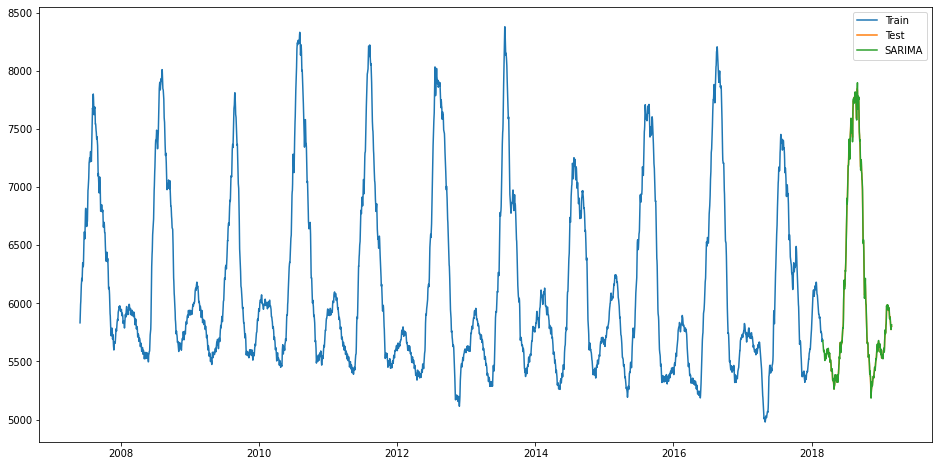

In [8]:
# Predictions
model = sm.tsa.statespace.SARIMAX(df_mean,
                                  order=(4, 1, 2), seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False).fit()
pred = model.predict(start="2018-03-01", end="2019-02-28", dynamic=False, full_results=True)
plt.figure(figsize=(16, 8))
plt.plot(train_mean, label='Train')
plt.plot(test_mean, label='Test')
plt.plot(pred, label='SARIMA')
plt.legend(loc='best')
plt.show()

In [9]:
# Predictions
model = sm.tsa.statespace.SARIMAX(df_mean,
                                  order=(4, 1, 2), seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.78616D+00    |proj g|=  2.25008D+00


 This problem is unconstrained.



At iterate    5    f=  4.58966D+00    |proj g|=  1.99552D-01

At iterate   10    f=  4.48865D+00    |proj g|=  1.57952D-01

At iterate   15    f=  4.45490D+00    |proj g|=  1.33551D-01

At iterate   20    f=  4.44361D+00    |proj g|=  1.88779D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  4.40698D+00    |proj g|=  1.45105D-01

At iterate   30    f=  4.39071D+00    |proj g|=  1.18405D-01

At iterate   35    f=  4.38054D+00    |proj g|=  1.60504D-01
  ys=-3.514E-04  -gs= 4.529E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  4.37821D+00    |proj g|=  2.05931D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40    122      3     1     0   2.059D+00   4.378D+00
  F =   4.3782142262210071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5758      0.022     25.852      0.000       0.532       0.619
ar.L2         -0.8882      0.015    -57.757      0.000      -0.918      -0.858
ar.L3          0.8683      0.015     57.023  

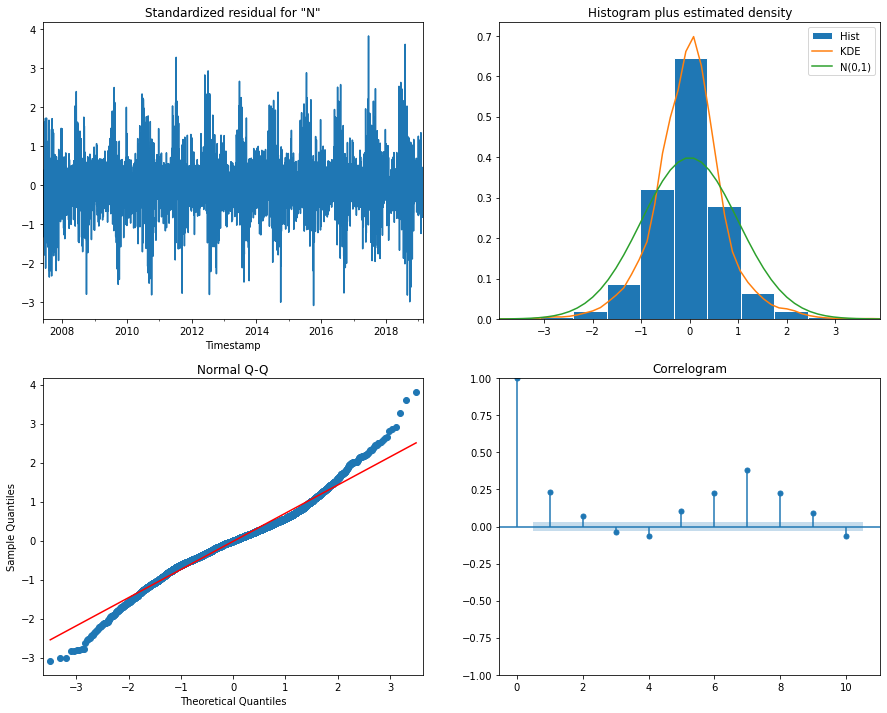

In [10]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [13]:
# https://www.cnblogs.com/lfri/p/12243268.html
# https://www.howtoing.com/a-guide-to-time-series-forecasting-with-arima-in-python-3/